In [1]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import recall_score, roc_auc_score,auc,roc_curve

In [2]:
train = pd.read_csv('churn-bigml-80.csv')
train["flag_muestra"] = "train"
test = pd.read_csv('churn-bigml-20.csv')
test["flag_muestra"] = "test"

In [3]:
data = train._append(test)
data['Area code'] = data['Area code'].astype(object)

In [4]:
data['Total minutes'] = data['Total day minutes'] + data['Total eve minutes'] + data['Total night minutes'] + data['Total intl minutes']
total_calls = data['Total day calls'] + data['Total eve calls'] + data['Total night calls'] + data['Total intl calls']
data.insert(loc=len(data.columns), column='Total calls', value=total_calls)
data['Total charge'] = data['Total day charge'] + data['Total eve charge'] + data['Total night charge'] + data['Total intl charge']
data = data.rename(columns = {'International plan':'International_plan'})
data = data.rename(columns = {'Voice mail plan':'Voice_mail_plan'})
data['c_International_plan'] = LabelEncoder().fit_transform(data.International_plan.values)
data['c_Voice_mail_plan'] = LabelEncoder().fit_transform(data.Voice_mail_plan.values)
data['Churn'] = data['Churn'].astype('int64')

In [5]:
data.to_csv('data.csv',index=False)

In [6]:
data2=data[['c_International_plan','c_Voice_mail_plan','Number vmail messages','Total minutes','Total charge','Customer service calls','Churn']]
data2.to_csv('data2.csv',index=False)
data2.head()

,c_International_plan,c_Voice_mail_plan,Number vmail messages,Total minutes,Total charge,Customer service calls,Churn
0,0,1,25,717.2,75.56,1,0
1,0,1,26,625.2,59.24,1,0
2,0,0,0,539.4,62.29,0,0
3,1,0,0,564.8,66.80,2,0
4,1,0,0,512.0,52.09,3,0


In [17]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [18]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 mins 43 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_carlo_4i8o6c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.722 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [19]:
data_df = pd.read_csv("data2.csv")

In [20]:
X = data_df.drop('Churn', axis=1)
y = data_df['Churn']


In [21]:
X[0:5]

,c_International_plan,c_Voice_mail_plan,Number vmail messages,Total minutes,Total charge,Customer service calls
0,0,1,25,717.2,75.56,1
1,0,1,26,625.2,59.24,1
2,0,0,0,539.4,62.29,0
3,1,0,0,564.8,66.80,2
4,1,0,0,512.0,52.09,3


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [30]:
train_df_smote = pd.DataFrame(X_train_smote, columns=X.columns)
train_df_smote['Churn'] = y_train_smote

In [31]:
train_h2o = h2o.H2OFrame(train_df_smote)
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
train_h2o.columns

['c_International_plan',
 'c_Voice_mail_plan',
 'Number vmail messages',
 'Total minutes',
 'Total charge',
 'Customer service calls',
 'Churn']

In [33]:
predictors = train_h2o.columns[:-1]
response_col = 'Churn'

In [34]:
train_h2o[response_col] = train_h2o[response_col].asfactor()
test_h2o[response_col] = test_h2o[response_col].asfactor()

In [38]:
models = {
    'GLM': H2OGeneralizedLinearEstimator(),
    'Boosting': H2OGradientBoostingEstimator(),
    'DeepLearning': H2ODeepLearningEstimator(),
    'RandomForest': H2ORandomForestEstimator(),
    #'AutoML': H2OAutoML(max_runtime_secs=3600, seed=1)
}

In [39]:
results = {'without_smote': {}, 'with_smote': {}}

In [40]:
for name, model in models.items():
    if name != 'AutoML':
        model.train(x=predictors, y=response_col, training_frame=train_h2o)
    else:
        model.train(x=predictors, y=response_col, training_frame=test_h2o)
    performance = model.model_performance(test_h2o)
    results['without_smote'][name] = {
        'ROC': performance.auc(),
        'GINI': 2 * performance.auc() - 1
    }

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [41]:
train_h2o_smote = h2o.H2OFrame(train_df_smote)
for name, model in models.items():
    if name != 'AutoML':
        model.train(x=predictors, y=response_col, training_frame=train_h2o_smote)
    else:
        model.train(x=predictors, y=response_col, training_frame=train_h2o_smote)
    performance = model.model_performance(test_h2o)
    results['with_smote'][name] = {
        'ROC': performance.auc(),
        'GINI': 2 * performance.auc() - 1
    }

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Python\Python311\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Test/Validation dataset has categorical column 'Churn' which is real-valued in the training data
  Request: POST /3/ModelMetrics/models/GLM_model_python_1700939216330_8115/frames/py_7_sid_9ed5
    data: {'auc_type': 'none'}


In [43]:
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Inicializar H2O
h2o.init(max_mem_size="8G")

# Cargar los datos
data_df = pd.read_csv("data2.csv")

# Dividir los datos en conjuntos de entrenamiento y prueba
X = data_df.drop('Churn', axis=1)
y = data_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convertir los conjuntos de datos a H2OFrames
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
train_h2o_smote = h2o.H2OFrame(pd.concat([X_train_smote, y_train_smote], axis=1))

# Asegurar que la columna de respuesta es un factor
train_h2o['Churn'] = train_h2o['Churn'].asfactor()
test_h2o['Churn'] = test_h2o['Churn'].asfactor()
train_h2o_smote['Churn'] = train_h2o_smote['Churn'].asfactor()

# Definir los predictores y la columna de respuesta
predictors = train_h2o.columns[:-1]
response_col = 'Churn'

# Definir y entrenar los modelos
models = {
    'GLM': H2OGeneralizedLinearEstimator(),
    'Boosting': H2OGradientBoostingEstimator(),
    'DeepLearning': H2ODeepLearningEstimator(),
    'RandomForest': H2ORandomForestEstimator(),
    #'AutoML': H2OAutoML(max_runtime_secs=3600, seed=1)
}

# Entrenar y evaluar modelos
roc_curves = {}

for smote_used in [False, True]:
    dataset = train_h2o_smote if smote_used else train_h2o
    smote_label = "smote" if smote_used else "without_smote"
    
    for name, model in models.items():
        # Entrenar modelo
        model.train(x=predictors, y=response_col, training_frame=dataset)
        
        # Obtener rendimiento del modelo en el conjunto de prueba
        performance = model.model_performance(test_h2o)
        
        # Obtener las métricas de la curva ROC
        roc_auc = performance.auc()
        fpr, tpr, thresholds = performance.roc()
        
        # Guardar las métricas de la curva ROC para la graficación
        roc_curves[f"{name}_{smote_label}"] = (fpr, tpr, roc_auc)

# Graficar las curvas ROC
plt.figure(figsize=(10, 8))

for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Guardar la figura
plt.savefig('/mnt/data/roc_curves_combined.png')

plt.show()

Checking whether there is an H2O instance running at http://localhost:54321.

 connected.


H2O_cluster_uptime:,26 mins 35 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_carlo_4i8o6c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.657 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


ValueError: not enough values to unpack (expected 3, got 2)

In [44]:
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator, H2ODeepLearningEstimator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Inicializar H2O
h2o.init(max_mem_size="8G")

# Cargar los datos
data_df = pd.read_csv("data2.csv")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,30 mins 31 secs
H2O_cluster_timezone:,America/Bogota
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_carlo_4i8o6c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.657 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [47]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data_df.drop('Churn', axis=1)
y = data_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convertir los conjuntos de datos a H2OFrames
train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
train_h2o_smote = h2o.H2OFrame(pd.concat([X_train_smote, y_train_smote], axis=1))

# Asegurar que la columna de respuesta es un factor
train_h2o['Churn'] = train_h2o['Churn'].asfactor()
test_h2o['Churn'] = test_h2o['Churn'].asfactor()
train_h2o_smote['Churn'] = train_h2o_smote['Churn'].asfactor()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [48]:
# Definir los predictores y la columna de respuesta
predictors = train_h2o.columns[:-1]
response_col = 'Churn'

# Definir y entrenar los modelos
models = {
    'GLM': H2OGeneralizedLinearEstimator(),
    'Boosting': H2OGradientBoostingEstimator(),
    'DeepLearning': H2ODeepLearningEstimator(),
    'RandomForest': H2ORandomForestEstimator(),
    #'AutoML': H2OAutoML(max_runtime_secs=3600, seed=1)
}



In [49]:
# Entrenar y evaluar modelos
roc_curves = {}

In [50]:
for smote_used in [False, True]:
    dataset = train_h2o_smote if smote_used else train_h2o
    smote_label = "smote" if smote_used else "without_smote"
    
    for name, model in models.items():
        # Entrenar modelo
        model.train(x=predictors, y=response_col, training_frame=dataset)
        
        # Obtener rendimiento del modelo en el conjunto de prueba
        performance = model.model_performance(test_h2o)
        
        # Obtener las métricas de la curva ROC
        roc_auc = performance.auc()
        fpr, tpr = performance.roc()  # Corregido aquí: solo desempaquetar fpr y tpr
        
        # Guardar las métricas de la curva ROC para la graficación
        roc_curves[f"{name}_{smote_label}"] = (fpr, tpr, roc_auc)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


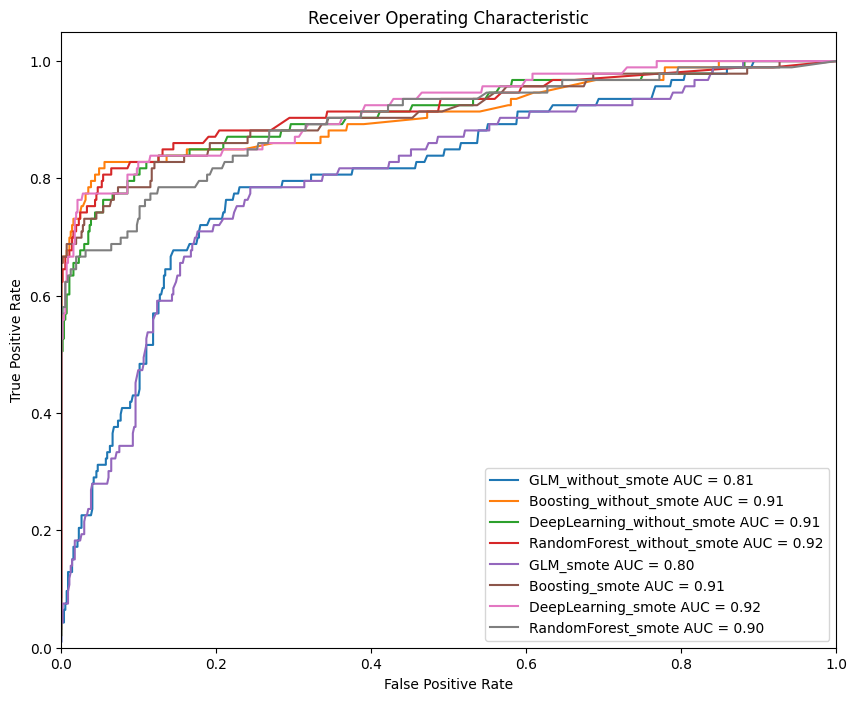

In [53]:
# Graficar las curvas ROC
plt.figure(figsize=(10, 8))

for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.2f}')

#plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')


plt.show()

# PARTE 2

In [54]:
# Carga de datos en el cluster H2O
data_h2o = h2o.import_file(
                path   = "Churn Modeling.csv",
                header = 1,
                sep    = ",",
                destination_frame = "datos_h2o"
            )

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [55]:
data_h2o.head()

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,1.56346e+07,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
3,1.56193e+07,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
4,1.57014e+07,Boni,699,France,Female,39,1,0,2,0,0,93826.6,0
5,1.57379e+07,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
6,1.5574e+07,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
7,1.55925e+07,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
8,1.56561e+07,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
9,1.57924e+07,He,501,France,Male,44,4,142051,2,0,1,74940.5,0
10,1.55924e+07,H?,684,France,Male,27,2,134604,1,1,1,71725.7,0


In [57]:
predictors = ["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard",'IsActiveMember','EstimatedSalary']
predictors

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [56]:
from h2o.estimators import H2OaKMeansEstimator

In [58]:
train, test = data_h2o.split_frame(ratios=[.9], seed=1234)

In [59]:
kmeans = H2OKMeansEstimator(k=3,
                            standardize=True,
                            seed=1234)

In [60]:
kmeans.train(x=predictors,
            training_frame=train,
            validation_frame=test)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OKMeansEstimator : K-means
Model Key: KMeans_model_python_1700939216330_8343


Model Summary: 
    number_of_rows    number_of_clusters    number_of_categorical_columns    number_of_iterations    within_cluster_sum_of_squares    total_sum_of_squares    between_cluster_sum_of_squares
--  ----------------  --------------------  -------------------------------  ----------------------  -------------------------------  ----------------------  --------------------------------
    8999              3                     0                                10                      57301.6                          71984                   14682.4

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 56577.27787832834
Total Sum of Square Error to Grand Mean: 71984.00056684844
Between Cluster Sum of Square Error: 15406.722688520094

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           3242    19956.2
    2           3120    18055.2
    3           2637    18565.8

ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 6281.721424716056
Total Sum of Square Error to Grand Mean: 8001.9471313237855
Between Cluster Sum of Square Error: 1720.225706607729

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           365     2250.52
    2           328     1914.51
    3           308     2116.7

Scoring History: 
    timestamp            duration    iterations    number_of_reassigned_observations    within_cluster_sum_of_squares
--  -------------------  ----------  ------------  -----------------------------------  -------------------------------
    2023-11-25 14:55:37  0.022 sec   0             nan                                  nan
    2023-11-25 14:55:37  0.081 sec   1             8999                                 96413.7
    2023-11-25 14:55:37  0.093 sec   2             1305                                 62559.8
    2023-11-25 14:55:37  0.102 sec   3             866                                  61434.4
    2023-11-25 14:55:37  0.109 sec   4             836                                  60623.3
    2023-11-25 14:55:37  0.116 sec   5             705                                  59147
    2023-11-25 14:55:37  0.124 sec   6             255                                  58328.3
    2023-11-25 14:55:37  0.131 sec   7             226                                  58200.7
    2023-11-25 14:55:37  0.139 sec   8             232                                  58068.2
    2023-11-25 14:55:37  0.147 sec   9             341                                  57869
    2023-11-25 14:55:37  0.154 sec   10            458                                  57301.6

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [61]:
prediction_train = kmeans.predict(train)
prediction_train

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


predict
0
2
1
0
1
0
1
2
2
1


In [62]:
prediction_train['predict'].unique()

C1
0
2
1


In [63]:
prediction_test = kmeans.predict(test)
prediction_test

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


predict
2
0
2
0
0
2
0
2
0
1


In [64]:
prediction_test['predict'].unique()

C1
2
0
1


In [65]:
train["Exited"] = prediction_train["predict"].asfactor()
train.head()

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,1.56346e+07,Hargrave,619,France,Female,42,2,0,1,1,1,101349,0
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,2
3,1.56193e+07,Onio,502,France,Female,42,8,159661,3,1,0,113932,1
5,1.57379e+07,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
6,1.5574e+07,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
7,1.55925e+07,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
8,1.56561e+07,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
9,1.57924e+07,He,501,France,Male,44,4,142051,2,0,1,74940.5,2
11,1.57678e+07,Bearce,528,France,Male,31,6,102017,2,0,0,80181.1,2
12,1.57372e+07,Andrews,497,Spain,Male,24,3,0,2,1,0,76390,1


In [67]:
train.group_by(['Exited']).count(na ="all").get_frame()

Exited,nrow
0,3242
1,3120
2,2637


In [ ]:
train.group_by(['Exited']).mean(["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard",'IsActiveMember','EstimatedSalary'], na="all").get_frame()